# Basic model builder tutorial

In this tutorial you will learn the basics of contructing a model_builder interface.

In our example, we construct a model_builder for a ROM of the advection diffusion equation. 

We will wrap around the adr_1d.py code.


In [1]:
#First, let's import the relavant modules:
import romtools
import os
import numpy as np
from matplotlib import pyplot as plt
from romtools.workflows import sampling
from romtools.workflows import ParameterSpace
import sys
sys.path.append('adr_1d/')
from adr_1d import advectionDiffusionProblem

module 'mpi4py' is not installed


In [5]:
'''
Here, we will interface around a ROM model for solving the 1D advection diffusion problem.
The model code is given in adr_1d/adr_1d_rom.py, and it solves a ROM of the 1d advection diffusion equation:

c u_x - nu * u_xx = 1


To run the code, we require:
    A file "params.dat" is required in the run directory. This .dat file contains the parameters c,nu.
    A "rom_data.npz" file in an "offline_data_directory" containing the basis, Phi, and reduced operators for the diffusion and reaction term
    The code is run as "python adr_1d_rom.py --offline_data_dir = path_to_offline_data_directory
 
Running the code outputs a solution.npz file with the keys x (grid) and u (solution)

'''

# We will start with defining a ROM class that meets the romtools model API
class adrRom:
    def __init__(self,base_dir,offline_directory,):
        self.offline_directory_ = offline_directory
        self.exec_dir_ = base_dir + '/adr_1d/'

    def populate_run_directory(self, run_directory: str, parameter_sample: dict):
        # Here, we need to make a params.dat file in the run_directory
        c = parameter_sample['c']
        nu = parameter_sample['nu']
        np.savetxt(run_directory + '/params.dat',np.array([c,nu]))

    def run_model(self, run_directory: str, parameter_sample: dict):
        os.chdir(run_directory)
        os.system('python ' + self.exec_dir_ + '/adr_1d_rom.py -offline_data_dir ' + self.offline_directory_)
        return 0


In [11]:
#Now, we can construct the model builder, which should return an adrRom. 
#The main logic that we need to add is how to construct the basis given training directories

class AdrRomModelBuilder:
    def __init__(self,myFom,adrRomFunctor):
        self.myFom_ = myFom
        self.adrRomFunctor_ = adrRomFunctor
        self.base_dir_ = os.getcwd()
        
    def build_from_training_dirs(self,offline_data_dir,training_dirs):
        # The offline_data_dir is a location where we should store any data required for running our ROMs
        # (e.g., input yamls, precomputed operators). For workflows leveraging the model builders, romtools will
        # create these directories
        
        #Similar, training_dirs is a list of directories where our FOMs have been run and training data is stored.

        # The advection diffusion FOM saves a solution.npz file with a key word 'u' containing the solution for each solution
        # We will loop through these solutions to construct a snapshot matrix
        for (i,training_dir) in enumerate(training_dirs):
            u = np.load(training_dir + '/solution.npz')['u']
            if i == 0:
                snapshots = u[:,None]
            else:
                snapshots = np.append(snapshots,u[:,None],axis=1)

        # We now have our snapshot matrix. We can now assemble our basis. Here we will just do a reduced basis
        # Note that ROM tools requires the snapshots to be in tensor form (n_vars, n_dofs , n_snaps)
        my_trial_space = romtools.vector_space.DictionaryVectorSpace(snapshots[None])

        # We can now assemble our ROM. First, grab the basis for the state variable 
        basis = my_trial_space.get_basis()[0]

        # We need to instatiate a realization of the FOM to get access to the FOM operators
        #Let's assemble the ROM operators
        Adr = basis.transpose() @ self.myFom_.Ad_ @ basis
        Acr = basis.transpose() @ self.myFom_.Ac_ @ basis
        fr = basis.transpose() @ self.myFom_.f_

        #We will save this to the offline_data_dir
        # Note we will also save the FOM operators so that we can evaluate the FOM
        # residual we if want
        np.savez(offline_data_dir + '/rom_data',Adr=Adr,Acr=Acr,fr=fr,basis=basis,
                Ac=self.myFom_.Ac_,Ad=self.myFom_.Ad_,f=self.myFom_.f_)

        #Now, we can instatiate the ROM:
        myRom = self.adrRomFunctor_(self.base_dir_,offline_data_dir)
        return myRom

#That's it! This model builder can be used in, e.g., a greedy workflow

In [12]:
#Let's give this model builder a try.
if __name__ == "__main__":
    #First, let's create some training data following the basic_sampling tutorial
    from ipynb.fs.full.external_model import adrExternalRomToolsModel
    myModel = adrExternalRomToolsModel()
    
    from ipynb.fs.full.parameter_space import BasicParameterSpace
    myParameterSpace = BasicParameterSpace()
    
    #The sampling algorithm requires a directory argument of where to put all the generated samples, files, etc.
    work_directory = os.getcwd() + '/model_builder_tutorial/'

    #Now we can run the sampling algorithm.
    sample_directories = sampling.run_sampling(myModel,myParameterSpace,work_directory,number_of_samples=5)


=======  Sample 0 ============
Running
Sample complete, run time = 0.14898300170898438
 
=======  Sample 1 ============
Running
Sample complete, run time = 0.09169697761535645
 
=======  Sample 2 ============
Running
Sample complete, run time = 0.08579683303833008
 
=======  Sample 3 ============
Running
Sample complete, run time = 0.09924101829528809
 
=======  Sample 4 ============
Running
Sample complete, run time = 0.08455801010131836
 


In [13]:
    #Great! Now, let's create our modelBuilder
    #To build an intrusive ROM, we need access to the operators of the FOM
    myIntrusiveFom = advectionDiffusionProblem(nx=33)
    myModelBuilder = AdrRomModelBuilder(myIntrusiveFom,adrRom)

    #Let's use this to build a ROM model using the data we just generated in our FOM sampling
    #We will create a directory for our offline data (e.g., rom bases, etc.)
    offline_data_dir =  os.getcwd() + '/model_builder_example_offline_data'
    if os.path.isdir(offline_data_dir):
        pass
    else:
        os.mkdir(offline_data_dir)
    myRomModel = myModelBuilder.build_from_training_dirs(offline_data_dir,sample_directories)

ROM-FOM error =  4.2469193422409324e-05


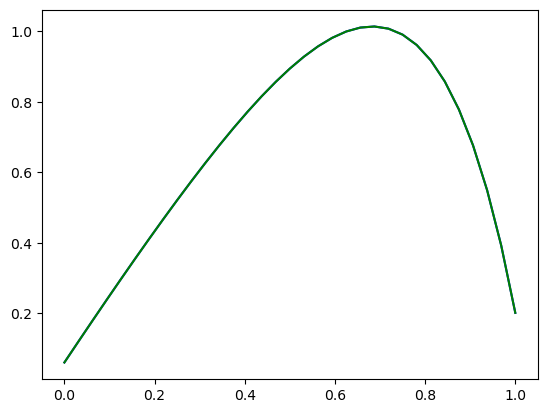

In [96]:

    # Let's test running our model and comparing it to the FOM!
    parameter_sample = {}
    parameter_sample['c'] = 0.5
    parameter_sample['nu'] = 1e-1
    run_directory = os.getcwd()

    #Let's run the ROM
    myRomModel.populate_run_directory(run_directory,parameter_sample)
    myRomModel.run_model(run_directory,parameter_sample)
    rom_solution = np.load(run_directory + '/solution.npz')
    plt.plot(rom_solution['x'],rom_solution['u'],color='blue',label='ROM')
    u_rom = rom_solution['u']

    #Now let's run the FOM
    myModel.populate_run_directory(run_directory,parameter_sample)
    myModel.run_model(run_directory,parameter_sample)
    fom_solution = np.load(run_directory + '/solution.npz')    
    u_fom = fom_solution['u']

    print('ROM-FOM error = ' , np.linalg.norm(u_rom - u_fom)/np.linalg.norm(u_fom))
    plt.plot(fom_solution['x'],fom_solution['u'],color='green',label='FOM')
    plt.show()
    